In [1]:
%load_ext autoreload
%autoreload 2

## 网络结构
我们按照作业要求，使用三层线性神经网络对 MNIST 数据集进行预测，其中第一层和第二层的激活函数为 ReLU，第三层输出前的激活函数为 softmax.

## 实际训练

In [2]:
import struct
import numpy as np
import os
from sklearn.metrics import accuracy_score

def read_file(folder_name: str) -> dict:
    """
    此函数从文件夹下读取所有形如idxn-ubyte的数据文件.
    :param folder_name: 文件夹字符串名.
    :return: 包含所有以文件名（不含后缀名）为key，ndarray为value的字典.
    """
    # 检查输入的文件夹是否存在，是否可读
    if not os.path.exists(folder_name):
        raise FileNotFoundError(f"Folder doesn't exists: {folder_name}")
    if not os.access(folder_name, os.R_OK):
        raise PermissionError(f"Folder not readable: {folder_name}")

    return_dict = {}
    for elements in os.scandir(folder_name):
        if elements.is_file():
            with open(elements.path, 'rb') as file:
                magic, size = struct.unpack('>II', file.read(8))
                dimension = magic & 0xFF  # 使用位运算获取存储数据的维数
                lengths = (size,) + struct.unpack(f">{dimension - 1}I",
                                                  file.read((dimension - 1) * 4))  #定义期望得到的ndarray结构
                data_temp = np.fromfile(file, dtype=np.uint8).reshape(lengths)  # 读取二进制文件并重整成正确的结构
                return_dict[os.path.splitext(elements.name)[0]] = data_temp
    return return_dict


# 读取数据
files = read_file('./dataset')
import lyutorch as lyu
img_train = lyu.tensor(files['train-images'] * 2 / 255 - 1, dtype=np.float32)
img_test = lyu.tensor(files['t10k-images'] * 2 / 255 - 1, dtype=np.float32)
label_train = lyu.tensor(files['train-labels'], dtype=np.int8)
label_test = lyu.tensor(files['t10k-labels'], dtype=np.int8)

# 将数据变成 one-hot 编码
one_hot_matrix = np.eye(10)
label_train = lyu.tensor(one_hot_matrix[label_train.flatten()].reshape(-1,10).squeeze())
label_test = lyu.tensor(one_hot_matrix[label_test.flatten()].reshape(-1,10).squeeze())

print(label_train.shape)
import lyutorch.nn as nn


class Net(nn.Module):
    def __init__(self, hidden_layer_size: int = 64):
        super(Net, self).__init__()
        self._hidden = hidden_layer_size
        self.fc1 = lyu.tensor(np.random.normal(size=(28 * 28, hidden_layer_size)), requires_grad=True)
        self.fc2 = lyu.tensor(np.random.normal(size=(hidden_layer_size, 10)), requires_grad=True)
        self.bias1 = lyu.tensor(np.random.normal(size=(1, hidden_layer_size)), requires_grad=True)
        self.bias2 = lyu.tensor(np.random.normal(size=(1, 10)), requires_grad=True)
        self.add_parameter('fc1', self.fc1)
        self.add_parameter('fc2', self.fc2)
        self.add_parameter('bias1', self.bias1)
        self.add_parameter('bias2', self.bias2)
        self.target = lyu.tensor(np.eye(10))

    def forward(self, x):
        x = x @ self.fc1
        x = x + self.bias1
        x = nn.functional.relu(x)
        x = x @ self.fc2
        x = x + self.bias2
        x = nn.functional.softmax(x, self.target)
        return x

    def l2normalization(self):
        return (lyu.linalg.norm2(self.fc1, order=2) + lyu.linalg.norm2(self.fc2, order=2) + lyu.linalg.norm2(
            self.bias1, order=2) + lyu.linalg.norm2(self.bias2, order=2)) * lyu.tensor(
            1 / (28 * 28 * self._hidden + self._hidden * 10 + 10 + self._hidden))

    def grad_off(self):
        for key, value in self.parameters():
            value.requires_grad = False

    def grad_on(self):
        for key, value in self.parameters():
            value.requires_grad = True


img_train = img_train.reshape((60000, 28 * 28))
img_test = img_test.reshape((10000, 28 * 28))
# 创建网络实例
net = Net(hidden_layer_size=32)
sgd = nn.Optimizer(net.parameters(), lr=0.01)
sgd.zero_grad()
losses32 = []
BATCH_SIZE = 32
data = nn.DataLoader([img_train, label_train], shuffle=True, batch_size=BATCH_SIZE)
batch = 0
size = len(img_train)
for epochs in range(5):
    for data_train in data:
        sgd.zero_grad()
        img = data_train[0]
        label = data_train[1]
        output = net(img)
        loss = nn.functional.cross_entropy_loss(output, label) + net.l2normalization()
        loss.backward()
        sgd.step()
        batch += 1
        losses32.append(loss.item())
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{batch * BATCH_SIZE:>5d}/{size:>5d}]")
    with lyu.no_grad():
        output = net(img_test)
        output = np.argmax(output,axis=1)
        label = np.argmax(label_test,axis=1)
        accuracy = accuracy_score(output, label)
        print(f"The accuracy on epoch {epochs} is {100*accuracy}%")


(60000, 10)
loss: 11.010602  [ 3200/60000]
loss: 5.825705  [ 6400/60000]
loss: 4.613001  [ 9600/60000]
loss: 2.611442  [12800/60000]
loss: 1.656574  [16000/60000]
loss: 1.359175  [19200/60000]
loss: 1.687747  [22400/60000]
loss: 1.281031  [25600/60000]
loss: 1.385370  [28800/60000]
loss: 1.560596  [32000/60000]
loss: 1.991470  [35200/60000]
loss: 1.322877  [38400/60000]
loss: 1.141665  [41600/60000]
loss: 2.294730  [44800/60000]
loss: 1.223078  [48000/60000]
loss: 1.145550  [51200/60000]
loss: 1.132429  [54400/60000]
loss: 1.289975  [57600/60000]
The accuracy on epoch 0 is 58.4%
loss: 1.556630  [60800/60000]
loss: 1.796993  [64000/60000]
loss: 1.326231  [67200/60000]
loss: 1.594261  [70400/60000]
loss: 1.284582  [73600/60000]
loss: 1.070579  [76800/60000]
loss: 0.980353  [80000/60000]
loss: 1.435255  [83200/60000]
loss: 1.727247  [86400/60000]
loss: 0.868025  [89600/60000]
loss: 1.053797  [92800/60000]
loss: 0.809375  [96000/60000]
loss: 1.146859  [99200/60000]
loss: 0.729457  [102400/

In [3]:
np.save('./data/losses32.npy', losses32)

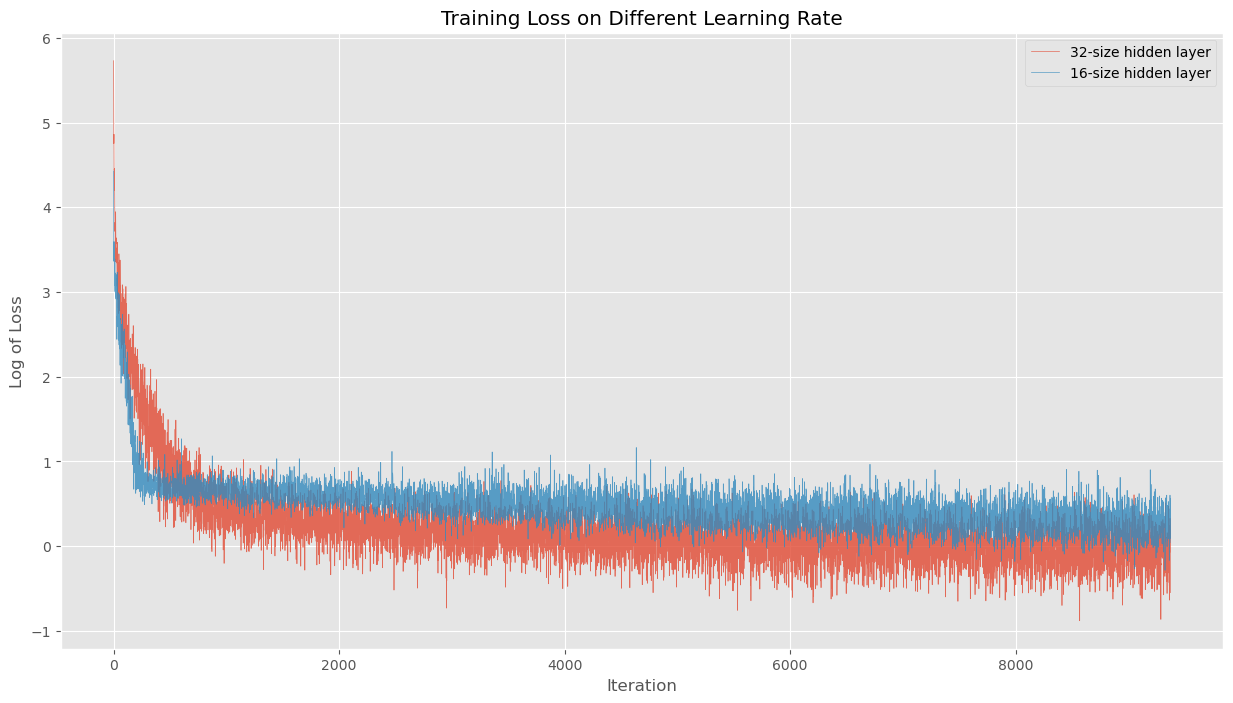

In [15]:
import matplotlib.pyplot as plt

losses32 = np.load("./data/losses32.npy")
losses16 = np.load("./data/losses16.npy")
plt.style.use("ggplot")
plt.figure(figsize=(15, 8))
plt.plot(np.log(losses32), label="32-size hidden layer", linewidth=0.5, alpha=0.8)
plt.plot(np.log(losses16), label="16-size hidden layer", linewidth=0.5, alpha=0.8)
plt.title("Training Loss on Different Hidden Layer Size")
plt.xlabel("Iteration")
plt.ylabel("Log of Loss")
plt.legend()

<Figure size 1500x800 with 0 Axes>

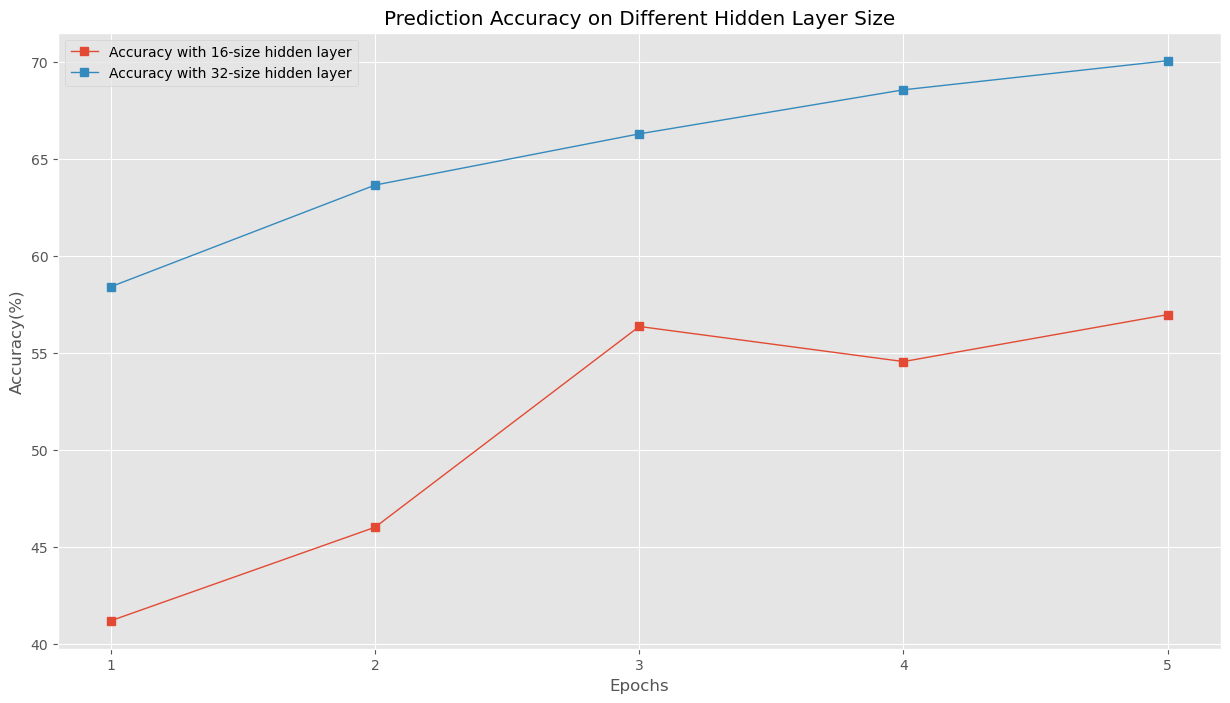

<Figure size 1500x800 with 0 Axes>

In [20]:
accu_16 = [41.18, 46.0, 56.35, 54.54, 56.96]
accu_32 = [58.4, 63.64, 66.28, 68.55, 70.05]
plt.style.use("ggplot")
plt.figure(figsize=(15, 8))
plt.plot([1,2,3,4,5],accu_16, label='Accuracy with 16-size hidden layer', linewidth=1,marker = 's')
plt.plot([1,2,3,4,5],accu_32, label='Accuracy with 32-size hidden layer', linewidth=1,marker = 's')
plt.title('Prediction Accuracy on Different Hidden Layer Size')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.xticks([1,2,3,4,5])
plt.figure(figsize=(15, 8))
